<a href="https://colab.research.google.com/github/450586509/reinforcement-learning-practice/blob/master/08_rl_seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### 任务 
Hebrew->English machine translation for words and short phrases

In [0]:
# If True, only translates phrases shorter than 20 characters (way easier).
EASY_MODE = True
# Useful for initial coding.
# If false, works with all phrases (please switch to this mode for homework assignment)

MODE = "he-to-en"  # way we translate. Either "he-to-en" or "en-to-he"
# maximal length of _generated_ output, does not affect training
MAX_OUTPUT_LENGTH = 50 if not EASY_MODE else 20
REPORT_FREQ = 100  # how often to evaluate validation score

数据预处理


数据的保存格式为：{ word1:[translation1,translation2,...], word2:[...],...}.

In [4]:
import numpy as np
from collections import defaultdict
word_to_translation = defaultdict(list)  # our dictionary

bos = '_'
eos = ';'

with open("main_dataset.txt") as fin:
    for line in fin:
        en, he = line[:-1].lower().replace(bos, ' ').replace(eos,                                         ' ').split('\t')
        word, trans = (he, en) if MODE == 'he-to-en' else (en, he)
        if len(word) < 3:
            continue
        if EASY_MODE:
            if max(len(word), len(trans)) > 20:
                continue
        word_to_translation[word].append(trans)
print("size = ", len(word_to_translation))

size =  130113


In [0]:
# get all unique lines in source language
all_words = np.array(list(word_to_translation.keys()))
# get all unique lines in translation language
all_translations = np.array(
    [ts for all_ts in word_to_translation.values() for ts in all_ts])

split the dataset


We hold out 10% of all words to be used for validation.

In [0]:
from sklearn.model_selection import train_test_split
train_words, test_words = train_test_split(
    all_words, test_size=0.1, random_state=42)

### Building vocabularies

We now need to build vocabularies that map strings to token ids and vice versa. We're gonna need these fellas when we feed training data into model or convert output matrices into english words.

In [0]:
import numpy as np


class Vocab:
    def __init__(self, tokens, bos="__BOS__", eos="__EOS__", sep=''):
        """
        A special class that handles tokenizing and detokenizing
        """
        assert bos in tokens, eos in tokens
        self.tokens = tokens
        self.token_to_ix = {t: i for i, t in enumerate(tokens)}

        self.bos = bos
        self.bos_ix = self.token_to_ix[bos]
        self.eos = eos
        self.eos_ix = self.token_to_ix[eos]
        self.sep = sep

    def __len__(self):
        return len(self.tokens)

    @staticmethod
    def from_lines(lines, bos="__BOS__", eos="__EOS__", sep=''):
        flat_lines = sep.join(list(lines))
        flat_lines = list(flat_lines.split(sep)) if sep else list(flat_lines)
        tokens = list(set(sep.join(flat_lines)))
        tokens = [t for t in tokens if t not in (bos, eos) and len(t) != 0]
        tokens = [bos, eos] + tokens
        return Vocab(tokens, bos, eos, sep)

    def tokenize(self, string):
        """converts string to a list of tokens"""
        tokens = list(filter(len, string.split(self.sep))) \
            if self.sep != '' else list(string)
        return [self.bos] + tokens + [self.eos]

    def to_matrix(self, lines, max_len=None):
        """
        convert variable length token sequences into  fixed size matrix
        example usage:
        >>>print( as_matrix(words[:3],source_to_ix))
        [[15 22 21 28 27 13 -1 -1 -1 -1 -1]
         [30 21 15 15 21 14 28 27 13 -1 -1]
         [25 37 31 34 21 20 37 21 28 19 13]]
        """
        max_len = max_len or max(map(len, lines)) + 2  # 2 for bos and eos

        matrix = np.zeros((len(lines), max_len), dtype='int32') + self.eos_ix
        for i, seq in enumerate(lines):
            tokens = self.tokenize(seq)
            row_ix = list(map(self.token_to_ix.get, tokens))[:max_len]
            matrix[i, :len(row_ix)] = row_ix

        return matrix

    def to_lines(self, matrix, crop=True):
        """
        Convert matrix of token ids into strings
        :param matrix: matrix of tokens of int32, shape=[batch,time]
        :param crop: if True, crops BOS and EOS from line
        :return:
        """
        lines = []
        for line_ix in map(list, matrix):
            if crop:
                if line_ix[0] == self.bos_ix:
                    line_ix = line_ix[1:]
                if self.eos_ix in line_ix:
                    line_ix = line_ix[:line_ix.index(self.eos_ix)]
            line = self.sep.join(self.tokens[i] for i in line_ix)
            lines.append(line)
        return lines

In [8]:

inp_voc = Vocab.from_lines(''.join(all_words), bos=bos, eos=eos, sep='')
out_voc = Vocab.from_lines(''.join(all_translations), bos=bos, eos=eos, sep='')

# Here's how you cast lines into ids and backwards.
batch_lines = all_words[:5]
batch_ids = inp_voc.to_matrix(batch_lines)
batch_lines_restored = inp_voc.to_lines(batch_ids)

print("lines")
print(batch_lines)
print("\nwords to ids (0 = bos, 1 = eos):")
print(batch_ids)
print("\nback to words")
print(batch_lines_restored)

lines
['אנרכיזם' 'אוטיזם קלאסי' 'אלבדו' 'אלבמה' 'אכילס']

words to ids (0 = bos, 1 = eos):
[[  0 184 132  64  75  42 103 185   1   1   1   1   1   1]
 [  0 184 176  20  42 103 185 115 156 163 184 117  42   1]
 [  0 184 163  96 122 176   1   1   1   1   1   1   1   1]
 [  0 184 163  96   8  27   1   1   1   1   1   1   1   1]
 [  0 184  75  42 163 117   1   1   1   1   1   1   1   1]]

back to words
['אנרכיזם', 'אוטיזם קלאסי', 'אלבדו', 'אלבמה', 'אכילס']


(array([   21.,   112.,  3098.,  8157., 11482., 12556., 11430.,  9568.,
         9254.,  9755., 10299., 11123., 11203., 10840.,  9316.,  7873.,
         6527.,  5523.,  4505.,  3684.]),
 array([ 1.  ,  1.95,  2.9 ,  3.85,  4.8 ,  5.75,  6.7 ,  7.65,  8.6 ,
         9.55, 10.5 , 11.45, 12.4 , 13.35, 14.3 , 15.25, 16.2 , 17.15,
        18.1 , 19.05, 20.  ]),
 <a list of 20 Patch objects>)

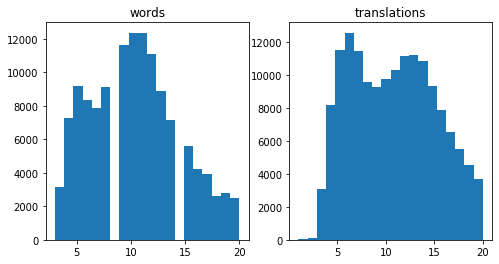

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("words")
plt.hist(list(map(len, all_words)), bins=20)

plt.subplot(1, 2, 2)
plt.title('translations')
plt.hist(list(map(len, all_translations)), bins=20)

### Step 3: deploy encoder-decoder (1 point)

seq2seq模型model提供以下接口：
- model.symbolic_translate(inp, **flags)-> out, logp：输入为：
- model.symbolic_score(inp, out, **flags) -> logp
- model.weights：所有层的权重。

In [10]:
import tensorflow as tf
import tensorflow.keras.layers as L
tf.reset_default_graph()
s = tf.InteractiveSession()

# ^^^ if you get "variable *** already exists": re-run this cell again

In [0]:



# This code implements a single-GRU seq2seq model. You will have to improve it later in the assignment.
# Note 1: when using several recurrent layers TF can mixed up the weights of different recurrent layers.
# In that case, make sure you both create AND use each rnn/gru/lstm/custom layer in a unique variable scope
# e.g. with tf.variable_scope("first_lstm"): new_cell, new_out = self.lstm_1(...)
#      with tf.variable_scope("second_lstm"): new_cell2, new_out2 = self.lstm_2(...)
# Note 2: everything you need for decoding should be stored in model state (output list of both encode and decode)
# e.g. for attention, you should store all encoder sequence and input mask
# there in addition to lstm/gru states.


class BasicTranslationModel:
    def __init__(self, name, inp_voc, out_voc,
                 emb_size, hid_size,):

        self.name = name
        self.inp_voc = inp_voc
        self.out_voc = out_voc

        with tf.variable_scope(name):
            self.emb_inp = L.Embedding(len(inp_voc), emb_size)
            self.emb_out = L.Embedding(len(out_voc), emb_size)
            self.enc0 = tf.nn.rnn_cell.GRUCell(hid_size)
            self.dec_start = L.Dense(hid_size)
            self.dec0 = tf.nn.rnn_cell.GRUCell(hid_size)
            self.logits = L.Dense(len(out_voc))

            # run on dummy output to .build all layers (and therefore create
            # weights)
            inp = tf.placeholder('int32', [None, None])
            out = tf.placeholder('int32', [None, None])
            h0 = self.encode(inp)
            h1 = self.decode(h0, out[:, 0])
            # h2 = self.decode(h1,out[:,1]) etc.

        self.weights = tf.get_collection(
            tf.GraphKeys.TRAINABLE_VARIABLES, scope=name)

    def encode(self, inp, **flags):
        """
        Takes symbolic input sequence, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :return: a list of initial decoder state tensors
        """
        inp_lengths = infer_length(inp, self.inp_voc.eos_ix)
        inp_emb = self.emb_inp(inp)

        _, enc_last = tf.nn.dynamic_rnn(
            self.enc0, inp_emb,
            sequence_length=inp_lengths,
            dtype=inp_emb.dtype)

        dec_start = self.dec_start(enc_last)
        return [dec_start]

    def decode(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits
        :param prev_state: a list of previous decoder state tensors
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch,n_tokens]
        """

        [prev_dec] = prev_state

        prev_emb = self.emb_out(prev_tokens[:, None])[:, 0]

        new_dec_out, new_dec_state = self.dec0(prev_emb, prev_dec)

        output_logits = self.logits(new_dec_out)

        return [new_dec_state], output_logits

    def symbolic_score(self, inp, out, eps=1e-30, **flags):
        """
        Takes symbolic int32 matrices of hebrew words and their english translations.
        Computes the log-probabilities of all possible english characters given english prefices and hebrew word.
        :param inp: input sequence, int32 matrix of shape [batch,time]
        :param out: output sequence, int32 matrix of shape [batch,time]
        :return: log-probabilities of all possible english characters of shape [bath,time,n_tokens]
        NOTE: log-probabilities time axis  is synchronized with out
        In other words, logp are probabilities of __current__ output at each tick, not the next one
        therefore you can get likelihood as logprobas * tf.one_hot(out,n_tokens)
        """
        first_state = self.encode(inp, **flags)

        batch_size = tf.shape(inp)[0]
        bos = tf.fill([batch_size], self.out_voc.bos_ix)
        first_logits = tf.log(tf.one_hot(bos, len(self.out_voc)) + eps)

        def step(blob, y_prev):
            h_prev = blob[:-1]
            h_new, logits = self.decode(h_prev, y_prev, **flags)
            return list(h_new) + [logits]

        results = tf.scan(step, initializer=list(first_state) + [first_logits],
                          elems=tf.transpose(out))

        # gather state and logits, each of shape [time,batch,...]
        states_seq, logits_seq = results[:-1], results[-1]

        # add initial state and logits
        logits_seq = tf.concat((first_logits[None], logits_seq), axis=0)

        # convert from [time,batch,...] to [batch,time,...]
        logits_seq = tf.transpose(logits_seq, [1, 0, 2])

        return tf.nn.log_softmax(logits_seq)

    def symbolic_translate(
            self,
            inp,
            greedy=False,
            max_len=None,
            eps=1e-30,
            **flags):
        """
        takes symbolic int32 matrix of hebrew words, produces output tokens sampled
        from the model and output log-probabilities for all possible tokens at each tick.
        :param inp: input sequence, int32 matrix of shape [batch,time]
        :param greedy: if greedy, takes token with highest probablity at each tick.
            Otherwise samples proportionally to probability.
        :param max_len: max length of output, defaults to 2 * input length
        :return: output tokens int32[batch,time] and
                 log-probabilities of all tokens at each tick, [batch,time,n_tokens]
        """
        first_state = self.encode(inp, **flags)

        batch_size = tf.shape(inp)[0]
        bos = tf.fill([batch_size], self.out_voc.bos_ix)
        first_logits = tf.log(tf.one_hot(bos, len(self.out_voc)) + eps)
        max_len = tf.reduce_max(tf.shape(inp)[1]) * 2

        def step(blob, t):
            h_prev, y_prev = blob[:-2], blob[-1]
            h_new, logits = self.decode(h_prev, y_prev, **flags)
            y_new = (
                tf.argmax(logits, axis=-1) if greedy
                else tf.multinomial(logits, 1)[:, 0]
            )
            return list(h_new) + [logits, tf.cast(y_new, y_prev.dtype)]

        results = tf.scan(
            step,
            initializer=list(first_state) + [first_logits, bos],
            elems=[tf.range(max_len)],
        )

        # gather state, logits and outs, each of shape [time,batch,...]
        states_seq, logits_seq, out_seq = (
            results[:-2], results[-2], results[-1]
        )

        # add initial state, logits and out
        logits_seq = tf.concat((first_logits[None], logits_seq), axis=0)
        out_seq = tf.concat((bos[None], out_seq), axis=0)
        states_seq = [
            tf.concat((init[None], states), axis=0)
            for init, states in zip(first_state, states_seq)
        ]

        # convert from [time,batch,...] to [batch,time,...]
        logits_seq = tf.transpose(logits_seq, [1, 0, 2])
        out_seq = tf.transpose(out_seq)
        states_seq = [
            tf.transpose(states, [1, 0] + list(range(2, states.shape.ndims)))
            for states in states_seq
        ]

        return out_seq, tf.nn.log_softmax(logits_seq)


### Utility functions ###

def initialize_uninitialized(sess=None):
    """
    Initialize unitialized variables, doesn't affect those already initialized
    :param sess: in which session to initialize stuff. Defaults to tf.get_default_session()
    """
    sess = sess or tf.get_default_session()
    global_vars = tf.global_variables()
    is_not_initialized = sess.run(
        [tf.is_variable_initialized(var) for var in global_vars]
    )
    not_initialized_vars = [
        v for (v, f)
        in zip(global_vars, is_not_initialized)
        if not f
    ]

    if len(not_initialized_vars):
        sess.run(tf.variables_initializer(not_initialized_vars))


def infer_length(seq, eos_ix, time_major=False, dtype=tf.int32):
    """
    compute length given output indices and eos code
    :param seq: tf matrix [time,batch] if time_major else [batch,time]
    :param eos_ix: integer index of end-of-sentence token
    :returns: lengths, int32 vector of shape [batch]
    """
    axis = 0 if time_major else 1
    is_eos = tf.cast(tf.equal(seq, eos_ix), dtype)
    count_eos = tf.cumsum(is_eos, axis=axis, exclusive=True)
    lengths = tf.reduce_sum(tf.cast(tf.equal(count_eos, 0), dtype), axis=axis)
    return lengths


def infer_mask(seq, eos_ix, time_major=False, dtype=tf.float32):
    """
    compute mask given output indices and eos code
    :param seq: tf matrix [time,batch] if time_major else [batch,time]
    :param eos_ix: integer index of end-of-sentence token
    :returns: mask, float32 matrix with '0's and '1's of same shape as seq
    """
    axis = 0 if time_major else 1
    lengths = infer_length(seq, eos_ix, time_major=time_major)
    mask = tf.sequence_mask(lengths, maxlen=tf.shape(seq)[axis], dtype=dtype)
    if time_major:
        mask = tf.transpose(mask)
    return mask


def select_values_over_last_axis(values, indices):
    """
    Auxiliary function to select logits corresponding to chosen tokens.
    :param values: logits for all actions: float32[batch,tick,action]
    :param indices: action ids int32[batch,tick]
    :returns: values selected for the given actions: float[batch,tick]
    """
    assert values.shape.ndims == 3 and indices.shape.ndims == 2
    batch_size, seq_len = tf.shape(indices)[0], tf.shape(indices)[1]
    batch_i = tf.tile(tf.range(0, batch_size)[:, None], [1, seq_len])
    time_i = tf.tile(tf.range(0, seq_len)[None, :], [batch_size, 1])
    indices_nd = tf.stack([batch_i, time_i, indices], axis=-1)

    return tf.gather_nd(values, indices_nd)

In [12]:
model = BasicTranslationModel('model', inp_voc, out_voc,emb_size=64, hid_size=128)

s.run(tf.global_variables_initializer())

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [13]:
# Play around with symbolic_translate and symbolic_score
inp = tf.placeholder_with_default(np.random.randint(
    0, 10, [3, 5], dtype='int32'), [None, None])
out = tf.placeholder_with_default(np.random.randint(
    0, 10, [3, 5], dtype='int32'), [None, None])

# translate inp (with untrained model)
sampled_out, logp = model.symbolic_translate(inp, greedy=False)
print("\nSymbolic_translate output:\n", sampled_out, logp)
print("\nSample translations:\n", s.run(sampled_out))

# score logp(out | inp) with untrained input
logp = model.symbolic_score(inp, out)
print("\nSymbolic_score output:\n", logp)
print("\nLog-probabilities (clipped):\n", s.run(logp)[:, :2, :5])



Instructions for updating:
Use `tf.random.categorical` instead.

Symbolic_translate output:
 Tensor("transpose_1:0", shape=(?, ?), dtype=int32) Tensor("LogSoftmax:0", shape=(?, ?, 283), dtype=float32)

Sample translations:
 [[  0 129  54 118 140 274 161  12 160  52 230]
 [  0 231 154  44 198 181  32 188  65 127 213]
 [  0 247  67 145  38  19 213 134 121  27 205]]

Symbolic_score output:
 Tensor("LogSoftmax_1:0", shape=(?, ?, 283), dtype=float32)

Log-probabilities (clipped):
 [[[  0.        -69.07755   -69.07755   -69.07755   -69.07755  ]
  [ -5.648181   -5.6530123  -5.6424174  -5.643757   -5.6453595]]

 [[  0.        -69.07755   -69.07755   -69.07755   -69.07755  ]
  [ -5.6331067  -5.6424427  -5.638038   -5.64289    -5.63463  ]]

 [[  0.        -69.07755   -69.07755   -69.07755   -69.07755  ]
  [ -5.6506763  -5.644626   -5.643043   -5.6479836  -5.6466594]]]


In [0]:
# Prepare any operations you want here
input_sequence = tf.placeholder('int32', [None, None])
greedy_translations, logp = model.symbolic_translate(input_sequence, greedy=True)


def translate(lines):
    """
    You are given a list of input lines. 
    Make your neural network translate them.
    :return: a list of output lines
    """
    # Convert lines to a matrix of indices
    lines_ix = inp_voc.to_matrix(lines)
    print("lines_ix shape={}".format(lines_ix.shape))

    # Compute translations in form of indices
    trans_ix = s.run(greedy_translations, {input_sequence:lines_ix})

    # Convert translations back into strings
    return out_voc.to_lines(trans_ix)



In [15]:
print("Sample inputs:", all_words[:3])
print("Dummy translations:", translate(all_words[:3]))

assert isinstance(greedy_translations,
                  tf.Tensor) and greedy_translations.dtype.is_integer, "trans must be a tensor of integers (token ids)"
assert translate(all_words[:3]) == translate(
    all_words[:3]), "make sure translation is deterministic (use greedy=True and disable any noise layers)"
assert type(translate(all_words[:3])) is list and (type(translate(all_words[:1])[0]) is str or type(
    translate(all_words[:1])[0]) is unicode), "translate(lines) must return a sequence of strings!"
print("Tests passed!")

Sample inputs: ['אנרכיזם' 'אוטיזם קלאסי' 'אלבדו']
lines_ix shape=(3, 14)
Dummy translations: ['υşυşרếuuµננ♭♭♭♭źll子子òρ’ρ桜ś仙仙', 'ήεtt桜桜仙桜仙桜ъ(桜((ạ(ạվοοwοwůwцạ', 'þļьь$ww4ļļ33御御一御一御一еееiеiíеi']
lines_ix shape=(3, 14)
lines_ix shape=(3, 14)
lines_ix shape=(3, 14)
lines_ix shape=(1, 9)
Tests passed!


In [0]:
### 打分函数

In [17]:
!pip install editdistance
import editdistance  # !pip install editdistance


def get_distance(word, trans):
    """
    A function that takes word and predicted translation
    and evaluates (Levenshtein's) edit distance to closest correct translation
    """
    references = word_to_translation[word]
    assert len(references) != 0, "wrong/unknown word"
    return min(editdistance.eval(trans, ref) for ref in references)


def score(words, bsize=100):
    """a function that computes levenshtein distance for bsize random samples"""
    assert isinstance(words, np.ndarray)

    batch_words = np.random.choice(words, size=bsize, replace=False)
    batch_trans = translate(batch_words)

    distances = list(map(get_distance, batch_words, batch_trans))

    return np.array(distances, dtype='float32')

In [18]:
[score(test_words, 10).mean() for _ in range(5)]


lines_ix shape=(10, 22)
lines_ix shape=(10, 22)
lines_ix shape=(10, 22)
lines_ix shape=(10, 20)
lines_ix shape=(10, 21)


[36.0, 43.7, 40.9, 36.5, 40.3]

### 开始训练

In [0]:
# import utility functions
#from basic_model_tf import initialize_uninitialized, infer_length, infer_mask, select_values_over_last_axis


class supervised_training:

    # variable for inputs and correct answers
    input_sequence = tf.placeholder('int32', [None, None])
    reference_answers = tf.placeholder('int32', [None, None])

    # Compute log-probabilities of all possible tokens at each step. Use model interface.
    logprobs_seq = model.symbolic_score(input_sequence, reference_answers)

    # compute mean crossentropy
    crossentropy = - select_values_over_last_axis(logprobs_seq, reference_answers)

    mask = infer_mask(reference_answers, out_voc.eos_ix)

    loss = tf.reduce_sum(crossentropy * mask)/tf.reduce_sum(mask)

    # Build weights optimizer. Use model.weights to get all trainable params.
    train_step = tf.train.AdamOptimizer().minimize(loss)


# intialize optimizer params while keeping model intact
initialize_uninitialized(s)

In [20]:
import random


def sample_batch(words, word_to_translation, batch_size):
    """
    sample random batch of words and random correct translation for each word
    example usage:
    batch_x,batch_y = sample_batch(train_words, word_to_translations,10)
    """
    # choose words
    batch_words = np.random.choice(words, size=batch_size)

    # choose translations
    batch_trans_candidates = list(map(word_to_translation.get, batch_words))
    batch_trans = list(map(random.choice, batch_trans_candidates))

    return inp_voc.to_matrix(batch_words), out_voc.to_matrix(batch_trans)
    
bx, by = sample_batch(train_words, word_to_translation, batch_size=3)
print("Source:")
print(bx)
print("Target:")
print(by)

Source:
[[  0  64  42 121   8  42 156  27   1   1   1   1   1   1   1   1   1]
 [  0 136 157  42 160 115  42  57 157 176 115   8 184  64  42  27   1]
 [  0 176 176  64 122 115 156 132  42 132  57  27 185   1   1   1   1]]
Target:
[[  0  28 268 229  85  53  82   2  33 173  33  40  53 254 120 159 254 106
   42  85  16   1]
 [  0 106 268  53 120  33 173  82   3 173 120  33  95  95  40   1   1   1
    1   1   1   1]
 [  0 235 268  53  28 173  85  40  72  72  42  72  57 254 268 106   1   1
    1   1   1   1]]


lines_ix shape=(100, 22)


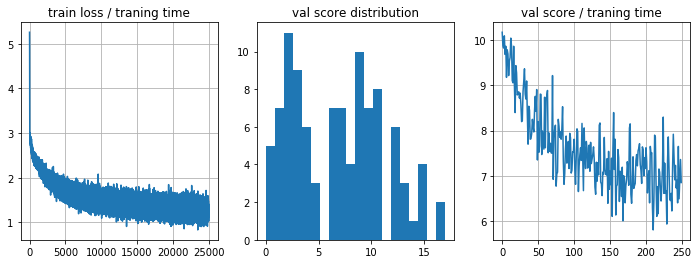

100%|██████████| 25000/25000 [28:56<00:00, 14.40it/s]

llh=1.279, mean score=6.946


In [21]:
from IPython.display import clear_output
from tqdm import tqdm, trange  # or use tqdm_notebook,tnrange

loss_history = []
editdist_history = []

for i in trange(25000):
    bx, by = sample_batch(train_words, word_to_translation, 32)

    feed_dict = {
        supervised_training.input_sequence: bx,
        supervised_training.reference_answers: by
    }

    loss, _ = s.run([supervised_training.loss,
                     supervised_training.train_step], feed_dict)
    loss_history.append(loss)

    if (i+1) % REPORT_FREQ == 0:
        clear_output(True)
        current_scores = score(test_words)
        editdist_history.append(current_scores.mean())
        plt.figure(figsize=(12, 4))
        plt.subplot(131)
        plt.title('train loss / traning time')
        plt.plot(loss_history)
        plt.grid()
        plt.subplot(132)
        plt.title('val score distribution')
        plt.hist(current_scores, bins=20)
        plt.subplot(133)
        plt.title('val score / traning time')
        plt.plot(editdist_history)
        plt.grid()
        plt.show()
        print("llh=%.3f, mean score=%.3f" %
              (np.mean(loss_history[-10:]), np.mean(editdist_history[-10:])))

# Note: it's okay if loss oscillates up and down as long as it gets better on average over long term (e.g. 5k batches)

In [22]:
for word in train_words[:10]:
    print("%s -> %s" % (word, translate([word])[0]))

test_scores = []
for start_i in trange(0, len(test_words), 32):
    batch_words = test_words[start_i:start_i+32]
    batch_trans = translate(batch_words)
    distances = list(map(get_distance, batch_words, batch_trans))
    test_scores.extend(distances)

print("Supervised test score:", np.mean(test_scores))

lines_ix shape=(1, 16)
כל אנשי סמיילי -> cassian mallians
lines_ix shape=(1, 16)
קטגוריה:ערוץ 2 -> 20
lines_ix shape=(1, 13)
עבודה מהבית -> abbat hamorica
lines_ix shape=(1, 8)
פראליה -> pralia
lines_ix shape=(1, 9)
קפלר 42 -> cappell 24
lines_ix shape=(1, 18)


  0%|          | 0/407 [00:00<?, ?it/s]

קטגוריה:מתאסלמים -> mathamslim
lines_ix shape=(1, 7)
בושמי -> boshmi
lines_ix shape=(1, 9)
לאונרדו -> laundrou
lines_ix shape=(1, 6)
שאמה -> shama
lines_ix shape=(1, 7)
עכברה -> achabara
lines_ix shape=(32, 21)
lines_ix shape=(32, 19)


  1%|          | 4/407 [00:00<00:23, 17.04it/s]

lines_ix shape=(32, 21)
lines_ix shape=(32, 21)
lines_ix shape=(32, 22)
lines_ix shape=(32, 17)


  2%|▏         | 8/407 [00:00<00:23, 17.00it/s]

lines_ix shape=(32, 22)
lines_ix shape=(32, 20)
lines_ix shape=(32, 22)
lines_ix shape=(32, 22)


  3%|▎         | 12/407 [00:00<00:24, 16.29it/s]

lines_ix shape=(32, 22)
lines_ix shape=(32, 22)
lines_ix shape=(32, 20)
lines_ix shape=(32, 21)


  4%|▍         | 16/407 [00:00<00:24, 15.92it/s]

lines_ix shape=(32, 22)
lines_ix shape=(32, 22)
lines_ix shape=(32, 20)
lines_ix shape=(32, 22)


  5%|▍         | 20/407 [00:01<00:24, 16.10it/s]

lines_ix shape=(32, 20)
lines_ix shape=(32, 22)
lines_ix shape=(32, 22)
lines_ix shape=(32, 21)


  6%|▌         | 24/407 [00:01<00:23, 15.99it/s]

lines_ix shape=(32, 22)
lines_ix shape=(32, 22)
lines_ix shape=(32, 19)
lines_ix shape=(32, 20)


  7%|▋         | 28/407 [00:01<00:23, 16.31it/s]

lines_ix shape=(32, 17)
lines_ix shape=(32, 21)
lines_ix shape=(32, 22)
lines_ix shape=(32, 22)


  8%|▊         | 32/407 [00:01<00:22, 16.69it/s]

lines_ix shape=(32, 21)
lines_ix shape=(32, 18)
lines_ix shape=(32, 21)
lines_ix shape=(32, 21)


  9%|▉         | 36/407 [00:02<00:22, 16.53it/s]

lines_ix shape=(32, 22)
lines_ix shape=(32, 22)
lines_ix shape=(32, 22)
lines_ix shape=(32, 21)


 10%|▉         | 40/407 [00:02<00:22, 16.63it/s]

lines_ix shape=(32, 20)
lines_ix shape=(32, 22)
lines_ix shape=(32, 19)
lines_ix shape=(32, 21)


 11%|█         | 44/407 [00:02<00:22, 16.30it/s]

lines_ix shape=(32, 22)
lines_ix shape=(32, 22)
lines_ix shape=(32, 20)
lines_ix shape=(32, 18)


 12%|█▏        | 48/407 [00:02<00:21, 16.68it/s]

lines_ix shape=(32, 20)
lines_ix shape=(32, 22)
lines_ix shape=(32, 19)
lines_ix shape=(32, 21)


 13%|█▎        | 52/407 [00:03<00:21, 16.76it/s]

lines_ix shape=(32, 22)
lines_ix shape=(32, 21)
lines_ix shape=(32, 22)
lines_ix shape=(32, 21)


 14%|█▍        | 56/407 [00:03<00:20, 17.23it/s]

lines_ix shape=(32, 19)
lines_ix shape=(32, 22)
lines_ix shape=(32, 22)
lines_ix shape=(32, 22)


 15%|█▍        | 60/407 [00:03<00:20, 17.01it/s]

lines_ix shape=(32, 18)
lines_ix shape=(32, 22)
lines_ix shape=(32, 22)
lines_ix shape=(32, 22)


 16%|█▌        | 64/407 [00:03<00:20, 16.53it/s]

lines_ix shape=(32, 22)
lines_ix shape=(32, 21)
lines_ix shape=(32, 22)
lines_ix shape=(32, 22)


 17%|█▋        | 68/407 [00:04<00:20, 16.40it/s]

lines_ix shape=(32, 21)
lines_ix shape=(32, 22)
lines_ix shape=(32, 22)
lines_ix shape=(32, 18)


 18%|█▊        | 72/407 [00:04<00:20, 16.56it/s]

lines_ix shape=(32, 22)
lines_ix shape=(32, 22)
lines_ix shape=(32, 21)
lines_ix shape=(32, 20)


 19%|█▊        | 76/407 [00:04<00:20, 16.42it/s]

lines_ix shape=(32, 21)
lines_ix shape=(32, 21)
lines_ix shape=(32, 21)
lines_ix shape=(32, 22)


 20%|█▉        | 80/407 [00:04<00:19, 16.36it/s]

lines_ix shape=(32, 20)
lines_ix shape=(32, 21)
lines_ix shape=(32, 22)
lines_ix shape=(32, 20)


 21%|██        | 84/407 [00:05<00:19, 16.55it/s]

lines_ix shape=(32, 22)
lines_ix shape=(32, 20)
lines_ix shape=(32, 22)
lines_ix shape=(32, 21)


 22%|██▏       | 88/407 [00:05<00:19, 16.52it/s]

lines_ix shape=(32, 22)
lines_ix shape=(32, 18)
lines_ix shape=(32, 22)
lines_ix shape=(32, 20)


 23%|██▎       | 92/407 [00:05<00:18, 16.83it/s]

lines_ix shape=(32, 21)
lines_ix shape=(32, 22)
lines_ix shape=(32, 21)
lines_ix shape=(32, 20)


 24%|██▎       | 96/407 [00:05<00:18, 16.83it/s]

lines_ix shape=(32, 21)
lines_ix shape=(32, 21)
lines_ix shape=(32, 22)
lines_ix shape=(32, 22)


 25%|██▍       | 100/407 [00:06<00:18, 16.86it/s]

lines_ix shape=(32, 21)
lines_ix shape=(32, 21)
lines_ix shape=(32, 20)
lines_ix shape=(32, 20)


 26%|██▌       | 105/407 [00:06<00:16, 17.87it/s]

lines_ix shape=(32, 19)
lines_ix shape=(32, 16)
lines_ix shape=(32, 21)
lines_ix shape=(32, 17)
lines_ix shape=(32, 22)


 27%|██▋       | 109/407 [00:06<00:16, 17.63it/s]

lines_ix shape=(32, 21)
lines_ix shape=(32, 21)
lines_ix shape=(32, 21)
lines_ix shape=(32, 20)


 28%|██▊       | 113/407 [00:06<00:17, 16.73it/s]

lines_ix shape=(32, 22)
lines_ix shape=(32, 22)
lines_ix shape=(32, 22)
lines_ix shape=(32, 22)


 29%|██▊       | 117/407 [00:07<00:17, 16.83it/s]

lines_ix shape=(32, 20)
lines_ix shape=(32, 21)
lines_ix shape=(32, 22)
lines_ix shape=(32, 22)


 30%|██▉       | 121/407 [00:07<00:16, 17.05it/s]

lines_ix shape=(32, 21)
lines_ix shape=(32, 22)
lines_ix shape=(32, 22)
lines_ix shape=(32, 20)


 31%|███       | 125/407 [00:07<00:16, 17.07it/s]

lines_ix shape=(32, 22)
lines_ix shape=(32, 22)
lines_ix shape=(32, 22)
lines_ix shape=(32, 22)


 32%|███▏      | 129/407 [00:07<00:16, 17.00it/s]

lines_ix shape=(32, 21)
lines_ix shape=(32, 19)
lines_ix shape=(32, 21)
lines_ix shape=(32, 21)


 33%|███▎      | 133/407 [00:07<00:16, 16.84it/s]

lines_ix shape=(32, 22)
lines_ix shape=(32, 21)
lines_ix shape=(32, 22)
lines_ix shape=(32, 22)


 34%|███▎      | 137/407 [00:08<00:15, 17.34it/s]

lines_ix shape=(32, 19)
lines_ix shape=(32, 21)
lines_ix shape=(32, 21)
lines_ix shape=(32, 22)


 35%|███▍      | 141/407 [00:08<00:15, 17.60it/s]

lines_ix shape=(32, 20)
lines_ix shape=(32, 21)
lines_ix shape=(32, 17)
lines_ix shape=(32, 22)


 36%|███▌      | 145/407 [00:08<00:14, 17.76it/s]

lines_ix shape=(32, 22)
lines_ix shape=(32, 20)
lines_ix shape=(32, 20)
lines_ix shape=(32, 18)


 37%|███▋      | 149/407 [00:08<00:14, 17.33it/s]

lines_ix shape=(32, 22)
lines_ix shape=(32, 20)
lines_ix shape=(32, 21)
lines_ix shape=(32, 20)


 38%|███▊      | 153/407 [00:09<00:14, 17.43it/s]

lines_ix shape=(32, 21)
lines_ix shape=(32, 22)
lines_ix shape=(32, 22)
lines_ix shape=(32, 20)


 39%|███▊      | 157/407 [00:09<00:14, 17.46it/s]

lines_ix shape=(32, 22)
lines_ix shape=(32, 22)
lines_ix shape=(32, 22)
lines_ix shape=(32, 20)


 40%|███▉      | 161/407 [00:09<00:14, 17.45it/s]

lines_ix shape=(32, 22)
lines_ix shape=(32, 21)
lines_ix shape=(32, 22)
lines_ix shape=(32, 21)


 41%|████      | 165/407 [00:09<00:14, 17.27it/s]

lines_ix shape=(32, 22)
lines_ix shape=(32, 22)
lines_ix shape=(32, 22)
lines_ix shape=(32, 21)


 42%|████▏     | 169/407 [00:10<00:13, 17.02it/s]

lines_ix shape=(32, 22)
lines_ix shape=(32, 21)
lines_ix shape=(32, 22)
lines_ix shape=(32, 21)


 43%|████▎     | 173/407 [00:10<00:13, 17.02it/s]

lines_ix shape=(32, 22)
lines_ix shape=(32, 22)
lines_ix shape=(32, 21)
lines_ix shape=(32, 20)


 43%|████▎     | 177/407 [00:10<00:13, 17.11it/s]

lines_ix shape=(32, 22)
lines_ix shape=(32, 22)
lines_ix shape=(32, 22)
lines_ix shape=(32, 22)


 44%|████▍     | 181/407 [00:10<00:13, 17.06it/s]

lines_ix shape=(32, 21)
lines_ix shape=(32, 22)
lines_ix shape=(32, 22)
lines_ix shape=(32, 21)


 45%|████▌     | 185/407 [00:10<00:13, 16.54it/s]

lines_ix shape=(32, 21)
lines_ix shape=(32, 22)
lines_ix shape=(32, 22)
lines_ix shape=(32, 22)


 46%|████▋     | 189/407 [00:11<00:12, 16.95it/s]

lines_ix shape=(32, 19)
lines_ix shape=(32, 22)
lines_ix shape=(32, 22)
lines_ix shape=(32, 20)


 47%|████▋     | 193/407 [00:11<00:12, 16.69it/s]

lines_ix shape=(32, 22)
lines_ix shape=(32, 20)
lines_ix shape=(32, 22)
lines_ix shape=(32, 21)


 48%|████▊     | 197/407 [00:11<00:12, 16.68it/s]

lines_ix shape=(32, 22)
lines_ix shape=(32, 22)
lines_ix shape=(32, 16)
lines_ix shape=(32, 22)


 49%|████▉     | 201/407 [00:11<00:12, 16.54it/s]

lines_ix shape=(32, 21)
lines_ix shape=(32, 22)
lines_ix shape=(32, 22)
lines_ix shape=(32, 22)


 50%|█████     | 205/407 [00:12<00:12, 16.42it/s]

lines_ix shape=(32, 22)
lines_ix shape=(32, 21)
lines_ix shape=(32, 19)
lines_ix shape=(32, 21)


 51%|█████▏    | 209/407 [00:12<00:11, 17.11it/s]

lines_ix shape=(32, 22)
lines_ix shape=(32, 21)
lines_ix shape=(32, 21)
lines_ix shape=(32, 22)


 52%|█████▏    | 213/407 [00:12<00:11, 17.08it/s]

lines_ix shape=(32, 22)
lines_ix shape=(32, 22)
lines_ix shape=(32, 19)
lines_ix shape=(32, 18)


 54%|█████▎    | 218/407 [00:12<00:11, 16.72it/s]

lines_ix shape=(32, 21)
lines_ix shape=(32, 21)
lines_ix shape=(32, 22)
lines_ix shape=(32, 21)


 55%|█████▍    | 222/407 [00:13<00:10, 17.09it/s]

lines_ix shape=(32, 21)
lines_ix shape=(32, 21)
lines_ix shape=(32, 21)
lines_ix shape=(32, 21)


 56%|█████▌    | 226/407 [00:13<00:10, 17.21it/s]

lines_ix shape=(32, 22)
lines_ix shape=(32, 22)
lines_ix shape=(32, 19)
lines_ix shape=(32, 19)


 57%|█████▋    | 230/407 [00:13<00:10, 17.10it/s]

lines_ix shape=(32, 22)
lines_ix shape=(32, 22)
lines_ix shape=(32, 22)
lines_ix shape=(32, 21)


 57%|█████▋    | 234/407 [00:13<00:09, 17.55it/s]

lines_ix shape=(32, 22)
lines_ix shape=(32, 19)
lines_ix shape=(32, 21)
lines_ix shape=(32, 20)


 58%|█████▊    | 238/407 [00:14<00:10, 16.80it/s]

lines_ix shape=(32, 22)
lines_ix shape=(32, 22)
lines_ix shape=(32, 22)
lines_ix shape=(32, 21)


 59%|█████▉    | 242/407 [00:14<00:09, 17.03it/s]

lines_ix shape=(32, 20)
lines_ix shape=(32, 20)
lines_ix shape=(32, 22)
lines_ix shape=(32, 22)


 60%|██████    | 246/407 [00:14<00:09, 16.97it/s]

lines_ix shape=(32, 21)
lines_ix shape=(32, 22)
lines_ix shape=(32, 22)
lines_ix shape=(32, 22)


 61%|██████▏   | 250/407 [00:14<00:09, 17.32it/s]

lines_ix shape=(32, 21)
lines_ix shape=(32, 20)
lines_ix shape=(32, 22)
lines_ix shape=(32, 22)


 62%|██████▏   | 254/407 [00:15<00:09, 16.90it/s]

lines_ix shape=(32, 21)
lines_ix shape=(32, 22)
lines_ix shape=(32, 20)
lines_ix shape=(32, 20)


 63%|██████▎   | 258/407 [00:15<00:08, 16.98it/s]

lines_ix shape=(32, 22)
lines_ix shape=(32, 22)
lines_ix shape=(32, 21)
lines_ix shape=(32, 22)


 64%|██████▍   | 262/407 [00:15<00:08, 16.84it/s]

lines_ix shape=(32, 22)
lines_ix shape=(32, 21)
lines_ix shape=(32, 21)
lines_ix shape=(32, 22)


 65%|██████▌   | 266/407 [00:15<00:08, 16.80it/s]

lines_ix shape=(32, 21)
lines_ix shape=(32, 22)
lines_ix shape=(32, 22)
lines_ix shape=(32, 22)


 66%|██████▋   | 270/407 [00:16<00:08, 16.13it/s]

lines_ix shape=(32, 22)
lines_ix shape=(32, 22)
lines_ix shape=(32, 21)
lines_ix shape=(32, 21)


 67%|██████▋   | 274/407 [00:16<00:08, 16.59it/s]

lines_ix shape=(32, 21)
lines_ix shape=(32, 21)
lines_ix shape=(32, 22)
lines_ix shape=(32, 21)


 68%|██████▊   | 278/407 [00:16<00:07, 16.98it/s]

lines_ix shape=(32, 22)
lines_ix shape=(32, 22)
lines_ix shape=(32, 22)
lines_ix shape=(32, 21)


 69%|██████▉   | 282/407 [00:16<00:07, 16.82it/s]

lines_ix shape=(32, 20)
lines_ix shape=(32, 22)
lines_ix shape=(32, 22)
lines_ix shape=(32, 20)


 70%|███████   | 286/407 [00:16<00:07, 17.07it/s]

lines_ix shape=(32, 19)
lines_ix shape=(32, 22)
lines_ix shape=(32, 22)
lines_ix shape=(32, 22)


 71%|███████▏  | 290/407 [00:17<00:07, 16.01it/s]

lines_ix shape=(32, 22)
lines_ix shape=(32, 22)
lines_ix shape=(32, 21)
lines_ix shape=(32, 20)


 72%|███████▏  | 294/407 [00:17<00:06, 16.41it/s]

lines_ix shape=(32, 20)
lines_ix shape=(32, 21)
lines_ix shape=(32, 21)
lines_ix shape=(32, 19)


 73%|███████▎  | 298/407 [00:17<00:06, 15.84it/s]

lines_ix shape=(32, 22)
lines_ix shape=(32, 22)
lines_ix shape=(32, 22)
lines_ix shape=(32, 22)

 74%|███████▍  | 302/407 [00:17<00:06, 16.15it/s]


lines_ix shape=(32, 21)
lines_ix shape=(32, 22)
lines_ix shape=(32, 20)
lines_ix shape=(32, 20)


 75%|███████▌  | 306/407 [00:18<00:06, 16.04it/s]

lines_ix shape=(32, 21)
lines_ix shape=(32, 22)
lines_ix shape=(32, 20)
lines_ix shape=(32, 22)


 76%|███████▌  | 310/407 [00:18<00:05, 16.19it/s]

lines_ix shape=(32, 20)
lines_ix shape=(32, 22)
lines_ix shape=(32, 20)
lines_ix shape=(32, 22)


 77%|███████▋  | 314/407 [00:18<00:05, 16.71it/s]

lines_ix shape=(32, 20)
lines_ix shape=(32, 20)
lines_ix shape=(32, 21)
lines_ix shape=(32, 21)


 78%|███████▊  | 318/407 [00:18<00:05, 16.73it/s]

lines_ix shape=(32, 22)
lines_ix shape=(32, 22)
lines_ix shape=(32, 21)
lines_ix shape=(32, 20)


 79%|███████▉  | 322/407 [00:19<00:05, 16.69it/s]

lines_ix shape=(32, 20)
lines_ix shape=(32, 21)
lines_ix shape=(32, 18)
lines_ix shape=(32, 21)


 80%|████████  | 326/407 [00:19<00:04, 16.42it/s]

lines_ix shape=(32, 19)
lines_ix shape=(32, 22)
lines_ix shape=(32, 21)
lines_ix shape=(32, 22)


 81%|████████  | 330/407 [00:19<00:04, 16.62it/s]

lines_ix shape=(32, 21)
lines_ix shape=(32, 22)
lines_ix shape=(32, 22)
lines_ix shape=(32, 22)


 82%|████████▏ | 334/407 [00:19<00:04, 16.78it/s]

lines_ix shape=(32, 22)
lines_ix shape=(32, 15)
lines_ix shape=(32, 22)
lines_ix shape=(32, 22)


 83%|████████▎ | 338/407 [00:20<00:04, 16.25it/s]

lines_ix shape=(32, 22)
lines_ix shape=(32, 21)
lines_ix shape=(32, 22)
lines_ix shape=(32, 22)


 84%|████████▍ | 342/407 [00:20<00:03, 16.43it/s]

lines_ix shape=(32, 22)
lines_ix shape=(32, 19)
lines_ix shape=(32, 22)
lines_ix shape=(32, 22)


 85%|████████▌ | 346/407 [00:20<00:03, 16.30it/s]

lines_ix shape=(32, 22)
lines_ix shape=(32, 21)
lines_ix shape=(32, 21)
lines_ix shape=(32, 21)


 86%|████████▌ | 350/407 [00:20<00:03, 16.20it/s]

lines_ix shape=(32, 22)
lines_ix shape=(32, 22)
lines_ix shape=(32, 22)
lines_ix shape=(32, 20)


 87%|████████▋ | 354/407 [00:21<00:03, 16.23it/s]

lines_ix shape=(32, 22)
lines_ix shape=(32, 22)
lines_ix shape=(32, 22)
lines_ix shape=(32, 22)


 88%|████████▊ | 358/407 [00:21<00:03, 16.13it/s]

lines_ix shape=(32, 22)
lines_ix shape=(32, 21)
lines_ix shape=(32, 22)
lines_ix shape=(32, 22)


 89%|████████▉ | 362/407 [00:21<00:02, 16.94it/s]

lines_ix shape=(32, 22)
lines_ix shape=(32, 20)
lines_ix shape=(32, 19)
lines_ix shape=(32, 21)


 90%|████████▉ | 366/407 [00:21<00:02, 17.10it/s]

lines_ix shape=(32, 22)
lines_ix shape=(32, 22)
lines_ix shape=(32, 22)
lines_ix shape=(32, 21)


 91%|█████████ | 370/407 [00:22<00:02, 17.82it/s]

lines_ix shape=(32, 19)
lines_ix shape=(32, 22)
lines_ix shape=(32, 19)
lines_ix shape=(32, 22)


 92%|█████████▏| 374/407 [00:22<00:01, 17.02it/s]

lines_ix shape=(32, 22)
lines_ix shape=(32, 18)
lines_ix shape=(32, 22)
lines_ix shape=(32, 22)


 93%|█████████▎| 378/407 [00:22<00:01, 17.28it/s]

lines_ix shape=(32, 22)
lines_ix shape=(32, 21)
lines_ix shape=(32, 17)
lines_ix shape=(32, 22)


 94%|█████████▍| 382/407 [00:22<00:01, 16.98it/s]

lines_ix shape=(32, 22)
lines_ix shape=(32, 20)
lines_ix shape=(32, 22)
lines_ix shape=(32, 22)


 95%|█████████▍| 386/407 [00:23<00:01, 16.27it/s]

lines_ix shape=(32, 22)
lines_ix shape=(32, 22)
lines_ix shape=(32, 22)
lines_ix shape=(32, 21)


 96%|█████████▌| 390/407 [00:23<00:01, 16.86it/s]

lines_ix shape=(32, 22)
lines_ix shape=(32, 19)
lines_ix shape=(32, 20)
lines_ix shape=(32, 22)


 97%|█████████▋| 394/407 [00:23<00:00, 16.26it/s]

lines_ix shape=(32, 22)
lines_ix shape=(32, 22)
lines_ix shape=(32, 22)
lines_ix shape=(32, 21)


 98%|█████████▊| 398/407 [00:23<00:00, 16.69it/s]

lines_ix shape=(32, 20)
lines_ix shape=(32, 22)
lines_ix shape=(32, 22)
lines_ix shape=(32, 20)


 99%|█████████▉| 402/407 [00:24<00:00, 16.23it/s]

lines_ix shape=(32, 22)
lines_ix shape=(32, 22)
lines_ix shape=(32, 21)
lines_ix shape=(32, 20)


100%|█████████▉| 406/407 [00:24<00:00, 16.50it/s]

lines_ix shape=(32, 22)
lines_ix shape=(32, 20)
lines_ix shape=(32, 21)
lines_ix shape=(20, 19)


100%|██████████| 407/407 [00:24<00:00, 16.73it/s]

Supervised test score: 6.713495235167538
